# ML - CFA Prediction for A351_S18_USLS

### ---Constructor and Definitions---

In [2]:
%matplotlib inline 
import ipywidgets as widgets
from matplotlib.pyplot import cm
import numpy as np
import pandas as pd
import glob
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import seaborn as sns
import xgboost
sns.set_style("whitegrid")
sns.set_context("poster")
# special matplotlib argument for improved plots
from matplotlib import rcParams
import os

rcParams['figure.figsize'] = 18,9


In [3]:
#some general lists to be used later
AC = ['A359', 'A351']
considered_AC = AC[0]
shells = ['upper', 'lower']
shell = shells[1]
failure_modes_US = ['RF_UL_FF_MS_comp', 'RF_UL_FF_LS', 'RF_UL_W_BUCK', 'RF_UL_FF_LB', 'RF_UL_JOINT_FR_to_CLIP_CL']
failure_modes_LS = ['RF_UL_FF_MS_comp', 'RF_UL_W_MS', 'RF_UL_FF_LS', 'RF_UL_JOINT_FR_to_CLIP_CL', 'RF_UL_JOINT_FR_to_CLIP_FR']
failure_modes_SS = []

In [4]:
#this function is called for the right feature selection depending on the selected failure mode
def set_features(failure_mode, area, AC_type):  
    if shell == 'upper':
        if failure_mode == 'RF_UL_FF_LS':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL', 
#                     'LC_type_code',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 
#                     'b_eff_111_UL', 'b_eff_121_UL', 'Delta_Fx_UL', 
                    'mbar', 'ANT_code',
#                     'Fy_FrCl_UL',
                   ]        
        elif failure_mode == 'RF_UL_FF_LB':
            return ['N_Fr_UL', 'M_Fr_UL', 'ANT_code',
                    'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_W_BUCK':
            return ['N_Fr_UL', 'M_Fr_UL', 'ANT_code',
                    'T_UL', 
                    'mbar',
                    'I_Fr', 'EA_Fr', 'yCG_Fr']
        # here
        elif failure_mode == 'RF_UL_FF_MS_comp':
            return ['N_Fr_UL', 'M_Fr_UL', 'EA_Fr',
                    'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr', 
                    'mbar', 'ANT_code'
                   ]
        elif failure_mode in ['RF_UL_OF_MS_comp', 'RF_UL_W_MS']:
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'EA_Fr', 'ANT_code',
                        'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_JOINT_FR_to_CLIP_CL':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL','f_xz_Skin_L_UL', 
                    #'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 'tw', 'h']
        else:
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'Delta_p_UL', 'T_GFEM', 'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr',
                    'b_eff_111_UL']
    elif shell == 'lower':
        if failure_mode == 'RF_UL_W_MS':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'EA_Fr',
                        'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_FF_MS_comp':
            return ['N_Fr_UL', 'M_Fr_UL', 'EA_Fr',
                    'T_GFEM', 'A_Fr', 'I_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_FF_LS':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL', 
                    'mbar',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr']
        elif failure_mode == 'RF_UL_JOINT_FR_to_CLIP_CL':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 'h', 'tw']
        elif failure_mode == 'RF_UL_JOINT_FR_to_CLIP_FR':
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'Delta_p_UL', 'T_GFEM', 'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr', 'h', 'tw']
        else:
            return ['N_Fr_UL', 'M_Fr_UL', 'T_UL', 'f_x_Skin_L_UL', 'f_z_Skin_L_UL',
                    'f_xz_Skin_L_UL', 'f_x_Skin_R_UL', 'f_z_Skin_R_UL', 'f_xz_Skin_R_UL',
                    'Delta_p_UL', 'T_GFEM', 'A_Fr', 'I_Fr', 'EA_Fr', 'yCG_Fr']
def encode_strings(df):
    lb_make = LabelEncoder()
    # LC_type
    df["LC_type_code"] = lb_make.fit_transform(df["LC_type"])
    cols = df.columns.tolist()
    cols.insert(24, cols.pop(cols.index('LC_type_code')))
    df = df.reindex(columns= cols)
    # Thermal
    df["Thermal_code"] = lb_make.fit_transform(df["Thermal"])
    cols = df.columns.tolist()
    cols.insert(26, cols.pop(cols.index('Thermal_code')))
    df = df.reindex(columns= cols)
    # Pressure
    df["Pressure_code"] = lb_make.fit_transform(df["Pressure"])
    cols = df.columns.tolist()
    cols.insert(28, cols.pop(cols.index('Pressure_code')))
    df = df.reindex(columns= cols)  
    # return updated df
    return df

In [5]:
#this function is used for the failure mode dropdown menu, the most critical failure modes are shown depending on 
# which shell is selected
def set_FM(v):
    #global considered_shell
    global FMs_curr
    if v == 'upper':
        #considered_shell = 'upper'
        FMs_curr = failure_modes_US
    elif v == 'lower':
        #considered_shell = 'lower'
        FMs_curr = failure_modes_LS
    elif v == 'side':
        #considered_shell = 'side'
        FMs_curr = failure_modes_SS
    else:
        FMs_curr = None

In [6]:
#this function is used to create "RF nice plots"
def create_plot(title, RFmax_plot):
    global xmin
    xmin = 0.5
    global xmax
    xmax = RFmax_plot*1.1
    scatter = 1.05
    scatter2 = 1.1
    plot1 = plt.plot([xmin, xmax], [xmin, xmax], linestyle='-', color = 'r', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin*scatter, xmax*scatter], linestyle=':', color = 'b', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin/scatter, xmax/scatter], linestyle=':', color = 'b', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin*scatter2, xmax*scatter2], linestyle=':', color = 'g', zorder=0)
    plot1 = plt.plot([xmin, xmax], [xmin/scatter2, xmax/scatter2], linestyle=':', color = 'g', zorder=0)
    plot1 = plt.title(title)
    plot1 = plt.legend(loc='best', shadow=False, scatterpoints=1)
    plot1 = plt.ylabel("Calculated Reserve Factor")
    plot1 = plt.xlabel("Predicted Reserve Factor")
    plot1= plt.legend(loc='lower right', shadow=False, scatterpoints=1, prop={'size': 13})
    axes = plt.gca()
    axes.set_xlim([xmin,xmax])
    axes.set_ylim([xmin,xmax])
    axes.set_aspect(aspect=0.65)

In [7]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### User Input

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
######### USER INPUT ##############
if shell == 'lower':
    input_file = 'Input\df_A351_S18_LS_v2.csv'
    df = pd.read_csv(input_file).drop(['Unnamed: 0'], axis=1)
else:
    # This file shall contain the data used for the model's training
    input_file = 'Input\df_A351_S18_US_SMM5Fus2_D4NC_IA920_CFA_ENV_ANT_v2.csv'
    # This file shall contain the data to be predicted
    validationMSN_file = 'Input\df_A351_S18_US_SMM5Fus2_D4NC_IA920_CFA_FTVL_ANT_v2.csv'
    df_in = pd.read_csv(input_file)
    df_val_in = pd.read_csv(validationMSN_file)
    both_shells = True
###################################

In [11]:
# For the previously chosen shell, the relavant failure modes are listed and the user can select the FM to be investigated
set_FM(shell)
a = widgets.Dropdown(options=FMs_curr, description='Failure Mode:',)
a

In [12]:
RFmax = 5

### -----------------------------------------------------------------------------------------------------------------------------------------------------------------

### Input Data Import

In [13]:
considered_FM = a.value
if shell == 'lower':
    features = set_features(considered_FM, shell, considered_AC)
    all_cols = features + [considered_FM] + ['LoadLoop']
    df = df.loc[df[considered_FM] != -9999.99]
    df_n = df[all_cols].dropna()
    df_n = df_n.loc[df_n[considered_FM] < RFmax]
    print('Considered Failure Mode: '+considered_FM)
    print(df.shape)

else:
    features = set_features(considered_FM, shell, considered_AC)
    all_cols = features + [considered_FM]
    df = df_in.loc[df_in[considered_FM] != -9999.99]
    df_val = df_val_in.loc[df_val_in[considered_FM] != -9999.99]
    df = df.loc[df[considered_FM] <= RFmax]
    df_val = df_val.loc[df_val[considered_FM] <= RFmax+1]
    
    print('Considered Failure Mode: '+considered_FM)
    print(df.shape)
    print(df_val.shape)
    lb_make = LabelEncoder()
    df['ANT_code'] = lb_make.fit_transform(df['ANT'])
    df_val['ANT_code'] = lb_make.fit_transform(df_val['ANT'])
    df_n = df[all_cols].dropna()
    df_val_n = df_val[all_cols].dropna()
df_n.head()

Considered Failure Mode: RF_UL_FF_MS_comp
(217779, 42)


,N_Fr_UL,M_Fr_UL,EA_Fr,T_GFEM,A_Fr,I_Fr,yCG_Fr,RF_UL_FF_MS_comp,LoadLoop
335,-9876.16,10425.00,27600000.0,-49.5685,347.529,282033.0,94.8174,4.88076,TLCS
347,-7575.96,100558.00,27600000.0,-49.5685,347.529,282033.0,94.8174,4.40523,TLCS
353,-7573.12,100536.00,27600000.0,-49.5685,347.529,282033.0,94.8174,4.40651,TLCS
539,-10570.70,9016.24,27600000.0,-49.5685,347.529,282033.0,94.8174,4.62663,TLCS
749,-10590.70,8774.17,27600000.0,-49.5685,347.529,282033.0,94.8174,4.62270,TLCS


In [14]:
'''result = considered_FM
if b == 'Lower shell':
    features = set_features(considered_FM, considered_shell)
    all_cols = features + [result] + ['LoadLoop']
else:
    features = set_features(considered_FM, considered_shell, considered_AC)
    all_cols = features + [result]
# if both_shells == True:
#     test_size = set_testsize_USLS(considered_FM, considered_shell, considered_AC)
# else:
#     test_size = set_testsize(considered_FM, considered_shell, considered_AC)   
'''


"result = considered_FM\nif b == 'Lower shell':\n    features = set_features(considered_FM, considered_shell)\n    all_cols = features + [result] + ['LoadLoop']\nelse:\n    features = set_features(considered_FM, considered_shell, considered_AC)\n    all_cols = features + [result]\n# if both_shells == True:\n#     test_size = set_testsize_USLS(considered_FM, considered_shell, considered_AC)\n# else:\n#     test_size = set_testsize(considered_FM, considered_shell, considered_AC)   \n"

### PLOT!!

In [15]:
df_f1 = df
df_f2 = pd.DataFrame(columns=['RF', 'FM'])

#the following loop only restructures data in oder to use the seaborn "hue" function
for rf in FMs_curr:
    list_curr = df_f1[rf].tolist()
    list2 = [rf]*len(list_curr)
    df_curr2 = pd.DataFrame({'RF':list_curr, 'FM':list2})
    df_f2 = pd.concat([df_f2, df_curr2], ignore_index=True)
df_f2 = df_f2.loc[df_f2['RF'] < 2.5].loc[df_f2['RF'] > 0]
df_f2.head()

,FM,RF
488,RF_UL_FF_MS_comp,2.35382
490,RF_UL_FF_MS_comp,2.10237
491,RF_UL_FF_MS_comp,2.20701
492,RF_UL_FF_MS_comp,2.46949
493,RF_UL_FF_MS_comp,1.98446


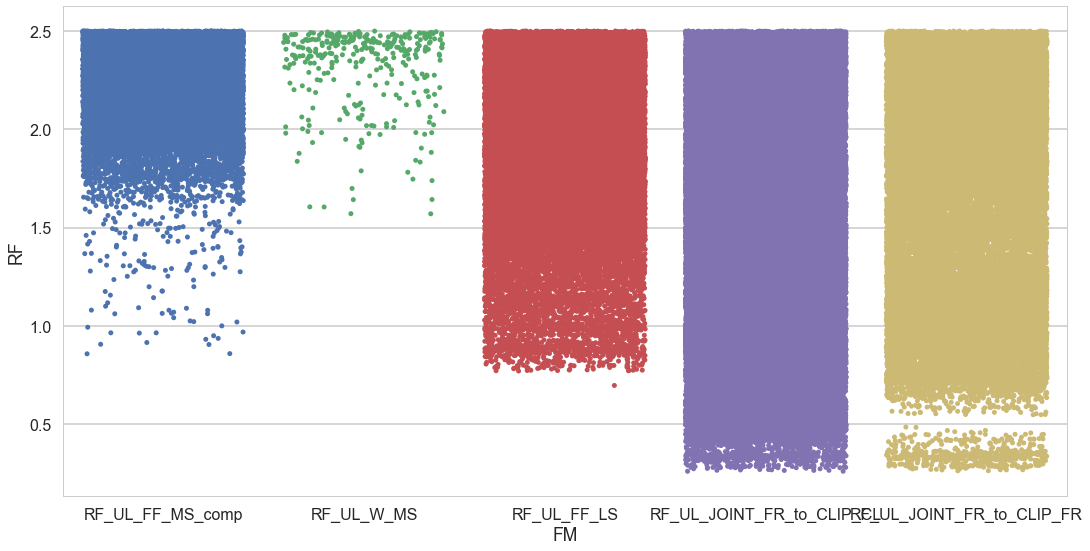

In [16]:
ax = sns.stripplot(x="FM", y="RF", data=df_f2, jitter=0.4)

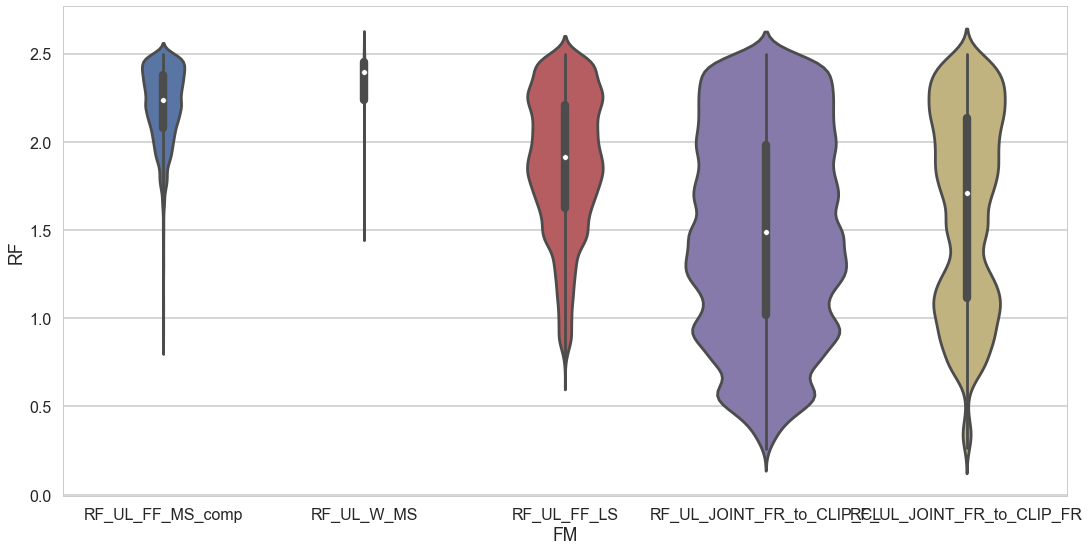

In [17]:
ax = sns.violinplot(x="FM", y="RF", data=df_f2, scale="count")

### Data Preparation

In [18]:
n_pred = 200

In [19]:
if shell == 'lower':
    ####################################
    df_train = df_n.loc[df_n['LoadLoop'] == 'TLCS']
    df_test = df_n.loc[df_n['LoadLoop'] == 'FTVL']
    ######################################

    df_train_X = df_train[features]
    df_test_X = df_test[features]
    df_train_y = df_train[considered_FM]
    df_test_y = df_test[considered_FM]

else:


    df_train_X = df_n[features]
    df_train_y = df_n[considered_FM]

    df_test_X = df_val_n[features]
    # .loc[df_val[considered_FM] < 2]
    df_test_y = df_val_n[considered_FM]
    # .loc[df_val[considered_FM] < 2]

print('Train:')
print('df_feature shape: ',df_train_X.shape)
print('df_result shape: ',df_train_y.shape)
print('Test:')
print('df_feature shape: ',df_test_X.shape)
print('df_result shape: ',df_test_y.shape)

Train:
df_feature shape:  (58452, 7)
df_result shape:  (58452,)
Test:
df_feature shape:  (11988, 7)
df_result shape:  (11988,)


In [20]:
# REMOVE
test_size = 0.1

In [21]:
X_train, y_train, X_test, y_test = df_train_X, df_train_y, df_test_X, df_test_y

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(58452, 7)
(11988, 7)
(58452,)
(11988,)


### Regression

In [22]:
c = widgets.Dropdown(options=['Automatic', 'Preselect'], description='Plot option:',)
c

In [23]:
### PLOT SCALING FACTOR ###
# scaling factor < 1 => zoom in, scaling factor > 1 => zoom out
plot_scaling_factor = 1
###########################

if c.value == 'Preselect':
    selected_models = ['Extra_Trees']
elif c.value == 'Automatic':
    selected_models = []
else:
    print('ERROR!!!')
    
                   
rng = np.random.RandomState(1)

regressor = {
#             'Linear_Regression':LinearRegression(),
#             'Decision_Tree':DecisionTreeRegressor(),
#             'Random_Forest':RandomForestRegressor(n_estimators= 90, random_state=rng, oob_score=True),
            'Extra_Trees':ExtraTreesRegressor(n_estimators=50, max_features=None, random_state=rng, criterion='mse',
                                             min_samples_leaf=1),
#             'AdaBoost':AdaBoostRegressor(),
#             'SVM':SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0,
#                         epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
             'xgb': xgboost.XGBRegressor(n_estimators=150, learning_rate=0.08,
                                         gamma=0.0, subsample=0.75, colsample_bytree=1, max_depth=25)
            }
    
color=['red', 'yellow', 'blue', 'green', 'pink', 'black']
i, rmse_min = 0, 100000   
summary_df = pd.DataFrame({'regressor':{},'loss (rmse)':{},'accuracy (r^2)':{}}).set_index('regressor')
create_plot('CFA RF Prediction for ' + considered_FM, RFmax*plot_scaling_factor)

for name, r in regressor.items():
    r.fit(X_train, y_train)
    y_prediction_curr = r.predict(X_test)
    rmse_curr, r2_curr = np.sqrt(sklearn.metrics.mean_squared_error(y_test, y_prediction_curr)), r2_score(y_test, y_prediction_curr)
    if rmse_curr < rmse_min:
        rmse_min = rmse_curr
        y_prediction_best = y_prediction_curr
        best_regressor = name
        color_auto = color[i]
    summary_df = summary_df.append({'regressor':name,'loss (rmse)':rmse_curr,'accuracy (r^2)':r2_curr}, ignore_index=True)
    if name in selected_models:
        plt.scatter(y_prediction_curr, y_test, s=40, c=color[i], alpha=0.5, edgecolor='k', label=name)
    i = i + 1
if c.value == 'Automatic':
    plt.scatter(y_prediction_best, y_test, s=40, c=color_auto, alpha=0.5, edgecolor='k', label=best_regressor)
plt.legend(loc='best', shadow=False, scatterpoints=1)
summary_df = summary_df.sort_values('loss (rmse)',ascending=True).reset_index().drop(['index'], axis=1)
print('Input file: ' + input_file)
print(shell)
# print('Test size: ' + str(test_size))
print('No. of training data: ' + str(y_train.shape[0]))
print('No. of testing data: ' + str(y_test.shape[0]))
summary_df

NameError: name 'xgboost' is not defined

### Feature Importance

In [ ]:
print('Feature importance for best regressor: ' + best_regressor)
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(regressor[best_regressor].feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()

### Extrapolation Threshold

In [ ]:
y_test_list = y_test.tolist()
y_pred_list = y_prediction_best.tolist()

In [ ]:
df_th = pd.DataFrame({'RF_calculated':{},'RF_predicted':{}, 'Failure Mode':{}})
df_th['RF_calculated'] = pd.Series(y_test_list)
df_th['RF_predicted'] = pd.Series(y_pred_list)
df_th['Failure Mode'] = considered_FM
RFmax_extrapol = RFmax-1
df_th = df_th.loc[df_th['RF_predicted'] < RFmax_extrapol]
df_th.head()

In [ ]:
### PLOT SCALING FACTOR ###
# scaling factor < 1 => zoom in, scaling factor > 1 => zoom out
plot_scaling_factor = 1
###########################

create_plot('CFA RF Prediction for ' + considered_FM, RFmax_extrapol*plot_scaling_factor)
plt.scatter(df_th['RF_predicted'], df_th['RF_calculated'], s=40, c=color_auto, alpha=0.5, edgecolor='k', label=best_regressor)
plt.legend(loc='best', shadow=False, scatterpoints=1)
rmse_th, r2_th = np.sqrt(sklearn.metrics.mean_squared_error(df_th['RF_calculated'], df_th['RF_predicted'])), r2_score(df_th['RF_calculated'], df_th['RF_predicted'])
print(len(df_th))
print('accuracy (r^2): ' + str(r2_th))
print('loss (rmse): ' + str(rmse_th))

In [ ]:
### PLOT SCALING FACTOR ###
# scaling factor < 1 => zoom in, scaling factor > 1 => zoom out
plot_scaling_factor = 1
scalor = int((len(df_th)/4000))
if scalor == 0:
    df_thred = df_th
else:
    df_thred = df_th[df_th.index % scalor == 0]
r2_th2 = truncate(r2_th,2)
###########################

create_plot('CFA RF Prediction for ' + considered_FM, RFmax_extrapol*plot_scaling_factor)
plt.scatter(df_thred['RF_predicted'], df_thred['RF_calculated'], s=40, c='b', alpha=0.5, edgecolor='k', label=best_regressor)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.text(xmin + 0.2, xmax-0.4, ("R^2 on test data: " + r2_th2), fontsize=20)
plt.text(xmin + 0.2, xmax-0.6, (str("RMSE test data : %.3f" % rmse_th)), fontsize=20)
#rmse_th, r2_th = np.sqrt(sklearn.metrics.mean_squared_error(df_th['RF_calculated'], df_th['RF_predicted'])), r2_score(df_th['RF_calculated'], df_th['RF_predicted'])

print('accuracy (r^2): ' + str(r2_th))
print('loss (rmse): ' + str(rmse_th))
type(r2_th2)

### Nice Plot Routine

In [ ]:
# note that these methods reqires several iterations of the above steps (for each failure mode to be investigated)
df_np = pd.DataFrame()
#first iteration

# df_np = df_th

#afterwards

df_np = pd.concat([df_np, df_th], ignore_index=False)

In [ ]:
RFmax = 10
df = df.loc[df[considered_FM] != -9999.99]
df = df.loc[df[considered_FM] < RFmax]
df2 = df[df.index % 100 == 0]

In [ ]:
df2.columns

In [ ]:
g = sns.pairplot(df2,vars=['RF_UL_FF_MS_comp','M_Fr_UL' ], hue='LoadLoop', size=5, aspect = 2.0)
fig = g.fig
fig.savefig('figout') 